In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import random
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix


In [2]:
conn = sqlite3.connect('data_std.db')
scripts = '''select * from credit_default_pred'''
data_std = pd.read_sql(scripts, conn)
data_std

,A105,A106,A116,A401,A509,A511,A517,A519,A609,A611,...,R906,SUD1,T310,XCNL,XCPA,XCTL,XGRP,XMTG,XPYR,是否違約
0,0.155906,0.010461,-0.401397,-0.046266,0.334499,-0.142139,-0.087050,0.294049,-0.404180,-0.013853,...,1.216554,0.150698,2.683424,-0.377492,-0.135021,-1.164123,-0.662574,-0.795279,-0.114314,0.0
1,0.082568,0.010461,-0.430237,0.006949,0.437604,-0.142139,-0.090957,0.392044,-0.412637,-0.014003,...,1.443770,0.205122,2.886790,2.649062,-0.135021,-1.145749,1.423786,-0.795279,-0.114314,0.0
2,0.096319,0.010461,-0.427540,-0.012908,0.707057,-0.142139,-0.090957,0.648142,-0.415240,-0.014008,...,1.300948,0.259546,3.034055,2.649062,-0.135021,-1.145749,1.423786,-0.795279,-0.114314,0.0
3,0.371911,0.010463,-0.363939,-0.065520,1.092298,-0.142139,-0.065388,1.014289,-0.418615,-0.013812,...,1.239275,0.313970,3.041067,2.649062,-0.135021,-0.358445,1.771513,-0.795279,-0.114314,0.0
4,0.568435,0.010464,-0.386761,-0.014787,1.312830,-0.142139,-0.026679,1.223891,-0.421827,-0.013747,...,0.950386,0.368394,3.181319,2.649062,-0.135021,-0.358445,1.771513,-0.795279,-0.114314,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9143,-0.156928,0.010463,-0.490901,0.478554,0.136572,-0.142139,-0.015670,0.105932,-0.307407,-0.014542,...,2.154632,2.037036,-0.689642,-0.377492,-0.135021,-0.840627,-0.662574,0.733134,-0.114314,0.0
9144,-0.344858,0.010462,-0.457150,0.083593,-0.017524,-0.142139,-0.028100,-0.040526,-0.276993,-0.014539,...,2.719427,2.091460,-0.331999,-0.377492,-0.135021,-0.770471,-0.662574,1.602591,-0.114314,0.0
9145,-0.003949,0.010462,-0.603419,0.127576,0.538983,-0.142139,0.018066,0.488398,-0.265120,-0.014546,...,1.346392,2.145884,0.095770,-0.377492,-0.135021,-0.770471,-0.662574,1.661794,-0.114314,0.0
9146,-0.205056,0.010462,-0.425229,0.115165,0.206028,-0.142139,0.074176,0.171945,-0.266991,-0.014547,...,1.924170,2.200308,0.502502,-0.377492,-0.135021,-0.978711,-0.662574,1.668944,-0.114314,1.0


In [3]:
len(np.where(data_std['是否違約']==1)[0])

121

## Train/Test Split
- Test/Train ratio = 0.7

In [4]:
from sklearn.model_selection import train_test_split
X = data_std.loc[:,data_std.columns.difference(['是否違約'])]
y = data_std['是否違約']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
len(np.where(y_train==1)[0])

82

## 重複抽樣 + Few shot learning
本研究採用bagging的方式來建立MLP模型<br>
bagging->組合不同樣本訓練出來的模型後，再將預測值取平均<br>
違約資料有樣本不平衡之問題(1僅占樣本的1%)，重複抽樣的方式還需穩定每組樣本0和1之比例(固定70%/30%)<br>


In [62]:
# 產生亂數組
n_task = 100
n_meta_update = 100
seed_sets = np.zeros((n_meta_update, n_task))
for i in range(n_meta_update):
    seeds = np.random.choice(10000000, n_task)
    seed_sets[i] = seeds
np.save('seed_sets.npy', seed_sets)

In [63]:
# 讀取預先製作的亂數組
seed_sets = np.load('seed_sets.npy')
val_seed_sets = np.load('val_seed_sets.npy')
seed_sets = seed_sets.astype(int)
val_seed_sets = val_seed_sets.astype(int)

In [33]:
class Credit_Maml:
    def __init__(self, train_X:np.ndarray, train_y:np.ndarray, n_meta_update:int=1, n_task:int=100, ways:list=[0,1], n_shots:int=5) -> None:
        self.n_meta_update = n_meta_update
        self.n_task = n_task
        self.ways = ways
        self.n_ways = len(ways)
        self.n_shots = n_shots
        self.train_X = train_X
        self.train_y = train_y
        self.seed_series = self.create_random_seeds('seed_sets')
        self.val_seed_series = self.create_random_seeds('val_seed_sets')
       


    def create_random_seeds(self, file_name):
        seed_sets = np.zeros((self.n_meta_update, self.n_task))
        for i in range(self.n_meta_update):
            seeds = np.random.choice(self.train_X.shape[0], self.n_task)
            seed_sets[i] = seeds
        np.save(f'{file_name}.npy', seed_sets)
        # 讀取預先製作的亂數組
        seed_sets = seed_sets.astype(int)
        return seed_sets
    
    def chose_one_class(self, random_state, way):
        # 每個 way 抽出 n_shot 筆資料
        np.random.seed(random_state)
        rand_index = np.random.choice(np.where(self.train_y==way)[0], self.n_shots)
        return self.train_X[rand_index], self.train_y[rand_index]
         
    
    def build_task_sample(self, random_state):
        # 建立 task 資料
        # train_X = train_X.values
        task_x = np.zeros((1, self.n_ways, self.n_shots, *self.train_X.shape[1:]))
        task_y = np.zeros((1, self.n_ways, self.n_shots, 1))
        for i in range(self.n_ways):
            task_x[0][i], task_y[0][i] = self.chose_one_class(random_state, self.ways[i])
        return task_x, task_y
    
    def generate_multiple_tasks(self, seed_series):
        # 建立 task set:(n_task, n_ways, n_shot, n_features)
        # if type(train_X) is not np.ndarray:
        #     train_X = train_X.values
        # train_y = tf.keras.utils.to_categorical(train_y, self.n_ways)
        task_sets_x = np.zeros((self.n_task, self.n_ways, self.n_shots, *self.train_X.shape[1:]))
        task_sets_y = np.zeros((self.n_task, self.n_ways, self.n_shots, 1))
        for i in range(self.n_task):
            task_sets_x[i], task_sets_y[i] = self.build_task_sample(seed_series[i])
        y_to_categorical = tf.keras.utils.to_categorical(task_sets_y, self.n_ways)
        # y = np.zeros((self.n_task, self.n_ways, self.n_shots, 1))
        # y[:,0,:,:] = [1,0]
        # y[:,1,:,:] = [0,1]
        return task_sets_x, y_to_categorical
    
    def create_model(self, n_features):
        # 清除背景中沒在使用的 model
        tf.keras.backend.clear_session()
        # model 為 3 層之 MLP
        # set initial weights of model
        initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(64, input_shape=(self.n_ways, self.n_shots, *n_features), activation='relu', kernel_initializer=initializer))
        # model.add(tf.keras.layers.Dropout(0.5))
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        # model.add(tf.keras.layers.Dropout(0.3))
        model.add(tf.keras.layers.Dense(64, activation='relu'))
        model.add(tf.keras.layers.Dense(2, activation='softmax'))
        # opt = tf.keras.optimizers.Adam()
        # model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, metrics=[tf.keras.metrics.BinaryAccuracy()])
        return model
    
    
    def CNN_model(self, n_features):
        # 清除背景中沒在使用的 model
        tf.keras.backend.clear_session()
        initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
        model = tf.keras.Sequential([
                tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(self.n_ways, self.n_shots, *n_features, 1)),
                tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                # tf.keras.layers.MaxPooling3D((2, 2, 2)),
                # tf.keras.layers.Flatten(),
                # tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(2, activation='softmax')
            ])
        return model


    def train_step(self, inner_lr=0.001, outer_lr=0.0001, early_stop = 10, select_model = 'MLP'):
        best_val_loss = np.inf
        best_weights = None
        # Create early stopping callback
        patience = early_stop
        early_stop_counter = 0
        history = {'loss': [], 'val_loss': []}
        opt_inner = tf.keras.optimizers.Adam(learning_rate=inner_lr)
        opt_outer = tf.keras.optimizers.Adam(learning_rate=outer_lr)
        if select_model == 'MLP':
            model = self.create_model(n_features=self.train_X.shape[1:])
        else:
            self.train_X = series_to_image(self.train_X, 11)
            model = self.CNN_model(n_features=(11,11))
            # print(self.train_X.shape)
        for i in range(self.n_meta_update):
            task_sets, y_true = self.generate_multiple_tasks(self.seed_series[i])
            query_sets, y_val_true = self.generate_multiple_tasks(self.val_seed_series[i])
            with tf.GradientTape(persistent=True) as outer_tape:
                task_loss = 0
                task_val_loss = 0
                for i in range(task_sets.shape[0]):
                    with tf.GradientTape(persistent=True) as inner_tape:
                        if select_model =='MLP':
                            # 調整維度以符合模型的輸入
                            x = task_sets[i].reshape((1, *task_sets[i].shape))
                            y = y_true[i].reshape((1, *y_true[i].shape))
                            # predict validation sets
                            val_X = query_sets[i].reshape((1, *query_sets[i].shape))
                            val_y = y_val_true[i].reshape((1, *y_val_true[i].shape))
                        else:
                            # 調整維度以符合模型的輸入
                            x = task_sets[i].reshape((1, *task_sets[i].shape, 1))
                            y_mean = tf.reduce_mean(y_true, axis = 1)
                            y_mean = tf.reduce_mean(y_mean, axis = 1)
                            y = y_mean[i].numpy().reshape((1, *y_mean[i].shape))
                            # predict validation sets
                            val_X = query_sets[i].reshape((1, *query_sets[i].shape, 1))
                            y_val_mean = tf.reduce_mean(y_val_true, axis = 1)
                            y_val_mean = tf.reduce_mean(y_val_mean, axis = 1)
                            val_y = y_val_mean[i].numpy().reshape((1, *y_val_mean[i].shape))
                        y_pred = model(x)
                        # 給定預測值(y_pred)和實際值(y)，用以計算loss
                        loss = tf.keras.losses.BinaryCrossentropy()(y, y_pred)
                        # val_pred = model(val_X)
                        
                    grads = inner_tape.gradient(loss, model.trainable_variables)
                    # updated_weights = [w - inner_lr*g for w, g in zip(model.trainable_variables, grads)]
                    opt_inner.apply_gradients(zip(grads, model.trainable_variables))
                    # train 
                    y_pred = model(x, training=True)
                    task_loss += tf.keras.losses.BinaryCrossentropy()(y, y_pred)
                    # validation predict with newly updated weights
                    val_pred = model(val_X)
                    task_val_loss += tf.keras.losses.BinaryCrossentropy()(val_y, val_pred)
                task_loss /= task_sets.shape[0]
                task_val_loss /= task_sets.shape[0]
                # Store loss data from both training and validation set
                history['loss'].append(task_loss.numpy())
                history['val_loss'].append(task_val_loss.numpy())
                if not patience:
                    if task_val_loss < best_val_loss:
                        best_val_loss = task_val_loss
                        best_weights = model.get_weights()
                        early_stop_counter = 0
                    else:
                        early_stop_counter += 1
                        if early_stop_counter >= patience:
                            break

            # Create optimizer and compile the model
            outer_grads = outer_tape.gradient(task_loss, model.trainable_variables)
            opt_outer.apply_gradients(zip(outer_grads, model.trainable_variables))
            # updated_weights = [w - outer_lr*g for w, g in zip(model.trainable_variables, outer_grads)]
        return model.trainable_variables, history


def plot_confusion_matrix(y_train, y_predict):
    conf_matrix= confusion_matrix(y_train, y_predict)
    LABELS=['Non_Default','Default'] #給出類別名稱
    plt.figure(figsize=(8,8))
    sns.heatmap(conf_matrix,xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("Predicted class")
    plt.xlabel("True class")
    plt.show()

def series_to_image(train_X:np.ndarray, shape):
    input_cnn = np.zeros((train_X.shape[0], shape**2))
    fill_empty = np.zeros(shape**2- train_X.shape[1])
    for i in range(train_X.shape[0]):
        input_cnn[i] = np.append(train_X[i], fill_empty)
    input_cnn = input_cnn.reshape((input_cnn.shape[0], shape, shape))
    return input_cnn

def predit_classes(weights, X, n_data):
    def network_dot(n_layers, current_layer, X_val, weights):
        output = np.dot(X_val, weights[2*current_layer])+weights[2*(current_layer+1)-1]
        if current_layer+1 == n_layers:
            return output
        return network_dot(n_layers, current_layer+1, output, weights)
    layers = (len(weights)//2)+1 if len(weights)%2==1 else len(weights)//2
    layer_output = network_dot(layers, current_layer=0, X_val=X, weights=weights)
    pred_class = np.argmax(layer_output.numpy(), axis=1)
    pred_class = pred_class.reshape((n_data))
    return pred_class
    

In [34]:
credit_pred = Credit_Maml(X_train.values, y_train.values, n_meta_update=50, n_task=100, ways = [0,1], n_shots=1)

In [8]:
credit_pred.CNN_model((11,11)).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 2, 10, 9, 9, 32)   320       
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 10, 7, 7, 64)   18496     
                                                                 
 dense (Dense)               (None, 2, 10, 7, 7, 2)    130       
                                                                 
Total params: 18,946
Trainable params: 18,946
Non-trainable params: 0
_________________________________________________________________


In [35]:
# x = series_to_image(X_train, 11)
x, y = credit_pred.generate_multiple_tasks(credit_pred.seed_series[0])
x.shape, y.shape

((100, 2, 1, 114), (100, 2, 1, 2))

In [38]:
result= {'weights':{}, 'history':{}}
for n_task in [10, 50, 100, 300, 500, 1000]:
    for n_shots in [1, 2, 5, 10, 30, 50]:
        for i in range(30):
            credit_pred = Credit_Maml(X_train.values, y_train.values, n_meta_update = 60, n_task = n_task, ways=[0,1], n_shots=n_shots)
            new_weight, history = credit_pred.train_step(inner_lr=0.001, outer_lr=1e-4, early_stop=10)
            np.save(f'./maml_model/maml_50_iter_{n_task}_tasks_2_ways_{n_shots}_shots_{i}', new_weight)
            np.save(f'./maml_model/history_50_iter_{n_task}_tasks_2_ways_{n_shots}_shots_{i}', history)
            result['weights'][str(i)] = new_weight
            result['history'][str(i)] = history


c:\Users\2022011702\Desktop\Leo\Credit Default Predict\.conda\lib\site-packages\numpy\lib\npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [10]:
credit_pred = Credit_Maml(X_train.values, y_train.values, n_meta_update = 60, n_task = n_task, ways=[0,1], n_shots=n_shots)
new_weight, history = credit_pred.train_step(inner_lr=0.001, outer_lr=1e-4, early_stop=10)

ValueError: `logits` and `labels` must have the same shape, received ((1, 2, 1, 2) vs (1, 2, 2)).

In [14]:
x, y = credit_pred.generate_multiple_tasks(credit_pred.seed_series[0])
x.shape, y.shape

((10, 2, 1, 114), (10, 2, 2))

In [533]:
np.random.seed(100)
n_val = 3000
n_ways = 2
n_shots = 10
val_index = np.random.choice(X_train.index, n_val)
X_val = X_train.loc[val_index,:]
y_val = y_train.loc[val_index]
X_val = series_to_image(X_val.values, 11)
# X_val = X_val.values.reshape((int(n_val/(n_ways*n_shots)), n_ways, n_shots, 114))
X_val = X_val.reshape((int(n_val/(n_ways*n_shots)), n_ways, n_shots, 11, 11))
y_val = y_val.values.reshape(n_val)
# new_weight = np.load('./maml_model/maml_9.npy', allow_pickle=True)
# pred_class = predit_classes(new_weight, X_val, n_val)
X_val.shape


(150, 2, 10, 11, 11)

In [534]:
pred_class = predit_classes(new_weight, X_val, n_val)

ValueError: shapes (150,2,10,11,11) and (3,3,1,32) not aligned: 11 (dim 4) != 1 (dim 2)

In [547]:
np.random.seed(100)
n_val = 3000
n_ways = 2
n_shots = 10
val_index = np.random.choice(X_train.index, n_val)
X_val = X_train.loc[val_index,:]
y_val = y_train.loc[val_index]
X_val = series_to_image(X_val.values, 11)
X_val = X_val.reshape((int(n_val/(n_ways*n_shots)), n_ways, n_shots, 11, 11, 1))
empty_model = credit_pred.CNN_model((11,11))
empty_model.set_weights(new_weight)
val_pred = empty_model.predict(X_val)

5/5 [==============================] - 0s 41ms/step


In [554]:
val_pred.shape

(150, 2)

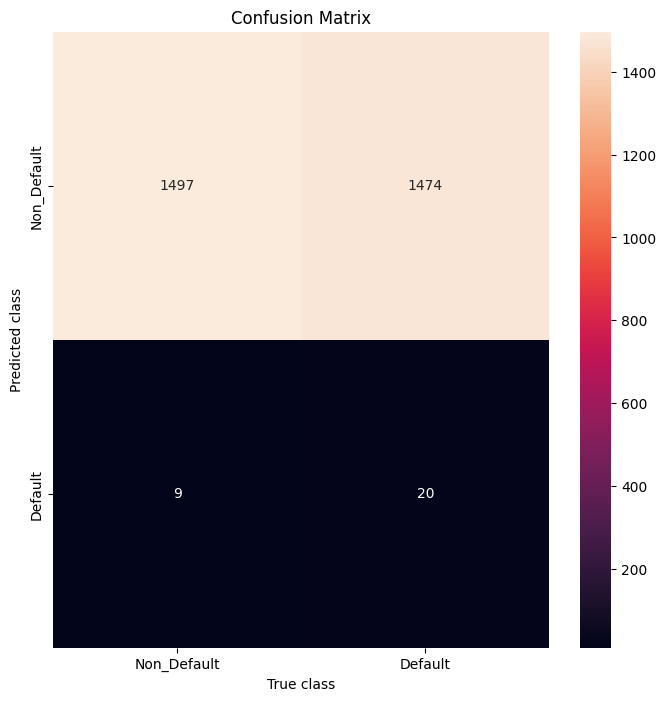

In [474]:
plot_confusion_matrix(y_val, pred_class)

In [537]:
len(pred_class)

3000

In [539]:
len(np.where(y_val==1)[0])

29

## Loss analysis

In [ ]:
# history = np.load('./maml_model/histrot_1.npy', allow_pickle=True)

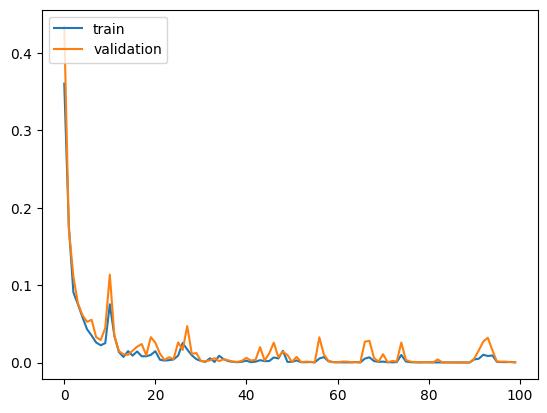

In [475]:
plt.plot(history['loss'], label = 'train')
plt.plot(history['val_loss'], label = 'validation')
plt.legend(loc = 2)